In [560]:
import numpy as np
from scipy.integrate import odeint
import copy as cp
import matplotlib.pylab as plt
from numpy.random import poisson
import pandas as pd

In [561]:
class Config:
    def __init__(self, params):
        params = cp.deepcopy(params)
        self.__dict__["_params"] = params
        for k, v in params.items():
            self.__dict__[k] = v

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self.__setattr__(key, value)

    def __setattr__(self, key, value):
        self._params[key] = value
        self.__dict__[key] = value

    def clone_me(self):
        return Config(self._params)

    def update(self, kwargs):
        return Config({**self._params, **kwargs})

    def _repr_html_(self):
        return pd.Series(self._params).to_frame().T._repr_html_()

    def getkeys(self):
        return list(self._params.keys())

In [562]:
def system(pop, t, cg):
    F, A, H = pop
    dFdt = cg.rho * F + cg.tau * A - cg.alpha * F*F - cg.mu*F - cg.beta * F * H
    dAdt = cg.r * cg.p * A + cg.beta * F * H - cg.gamma * (A + H) * A - (cg.d + cg.nu) * A
    dHdt = cg.r * H + cg.r * (1 - cg.p) * A - cg.gamma * (A + H) * H - cg.d * H - cg.beta * F * H
    return [dFdt, dAdt, dHdt]

In [578]:
def sys_birth(pop, cg, V):
    F, A, H = pop/V
    bF = cg.rho * F + cg.tau * A
    bA = cg.r * cg.p * A + cg.beta * F * H
    bH = cg.r * H + cg.r * (1 - cg.p) * A
    return np.array([bF, bA, bH])

def sys_death(pop, cg, V):
    F, A, H = pop/V
    dF = cg.alpha * F*F + cg.mu*F + cg.beta * F * H
    dA = cg.gamma * (A + H) * A + (cg.d + cg.nu) * A
    dH = cg.gamma * (A + H) * H + cg.d * H + cg.beta * F * H
    return np.array([dF, dA, dH])

def tau_leap(init, birth_rate, death_rate, Tmax, dt, cg, V):
    state = [init]
    time = [0]
    tseries = np.arange(0, Tmax - 1, 1)
    for i in tseries:
        br = birth_rate(init, cg, V)
        bn = np.random.poisson(init * np.exp(br * dt))
        dr = death_rate(init, cg, V)
        dn = np.random.poisson(init * np.exp(dr * dt))
        print(br[0], dr[0])
        init = init + bn - dn
        if all(init > 0):
            state.append(init)
            time.append(i + 1)
        else:
            break
    return dict(t = time, x = np.array(state))

In [ ]:
def tau(rho, nu, cg):
    # if rho.size > 1:
    #     assert isinstance(rho, np.ndarray), "mutant rho has to be a numpy array"
    # if nu.size > 1:
    #     assert isinstance(nu, np.ndarray), "mutant nu value has to be a numpy array"
    return cg.theta - cg.v * rho**cg.h + (cg.eta * nu * (nu + cg.d)**cg.g)/cg.nu_max

def F_birth_mut(pop_F, pop_A, cg, V, rho_mut, nu_mut):
    # assert isinstance(rho_mut, np.ndarray), "mutant rho has to be a numpy array"
    # assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    # assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    # assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return rho_mut * pop_F/V + tau(rho_mut, nu_mut, cg) * pop_A/V

def A_birth_mut(pop_F, pop_A, pop_H, cg, V):
    # assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    # assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.r * cg.p * pop_A/V + cg.beta * (pop_F/V) * (pop_H/V)

def H_birth_mut(pop_A, pop_H, cg, V):
    # assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.r * pop_H/V + cg.r * (1 - cg.p) * pop_A.sum()/V


def F_death_mut(pop_F, pop_H, cg, V):
    # assert isinstance(rho_mut, np.ndarray), "mutant rho has to be a numpy array"
    # assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    # assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    # assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.alpha * (pop_F/V) * (pop_F.sum())/V + cg.mu * pop_F/V + cg.beta * (pop_F/V) * (pop_H/V)


def A_death_mut(pop_F, pop_A, pop_H, cg, V, nu_mut):
    # assert isinstance(nu_mut, np.ndarray), "mutant nu value has to be a numpy array"
    # assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    # assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.gamma * ((pop_A.sum() + pop_H)/V) * pop_A/V + (cg.d + nu_mut) * pop_A/V

def H_death_mut(pop_F, pop_A, pop_H, cg, V):
    # assert isinstance(pop_F, np.ndarray), "F population has to be a numpy array"
    # assert isinstance(pop_A, np.ndarray), "A population has to be a numpy array"
    return cg.gamma * ((pop_A.sum() + pop_H)/V) * pop_H/V + cg.d * pop_H/V + cg.beta * (pop_F/V) * (pop_H/V)

def tau_leap_symbiosis_mutation(pop_init, Tmax, dt, cg, V, trait_init, sigma_rho, sigma_nu, mutant_rate):
    F_state = [pop_init[0:1]]
    A_state = [pop_init[1:2]]
    H_state = [pop_init[2:3]]
    rho_val = [trait_init[0:1]]
    nu_val = [trait_init[1:2]]
    tau_val = [tau(trait_init[0:1], trait_init[1:2], cg)]
    time = [0]
    for i in range(Tmax):
        if all(F_state[i] > 0 and A_state[i] > 0 and H_state[i] > 0):
            br = A_birth_mut(F_state[i], A_state[i], H_state[i], cg, V) # rate
            dr = A_death_mut(F_state[i], A_state[i], H_state[i], cg, V, nu_val[i]) # rate
            A_change = poisson(A_state[i] * np.exp(br * dt)) - poisson(A_state[i] * np.exp(dr * dt)) # intergers
            br = H_birth_mut(A_state[i], H_state[i], cg, V) # rate
            dr = H_death_mut(F_state[i], A_state[i], H_state[i], cg, V) # rate
            H_change = poisson(H_state[i] * np.exp(br * dt)) - poisson(H_state[i] * np.exp(dr * dt)) # intergers

            br = F_birth_mut(F_state[i], A_state[i], cg, V, rho_val[i], nu_val[i]) # rate
            dr = F_death_mut(F_state[i], H_state[i], cg, V) # rate
            F_change = poisson(F_state[i] * np.exp(br * dt)) - poisson(F_state[i] * np.exp(dr * dt)) # intergers
            # Number of mutants arise with each parent
            new_mut_arise = np.random.binomial(F_change * (F_change > 0), mutant_rate)
            ismutate = new_mut_arise > 0
            # Change in F population after mutation
            F_change_after_mut = F_change - new_mut_arise
            # arised mutants with corresponding parents' value
            rh = np.random.normal(rho_val[i], sigma_rho) * ismutate
            nn = np.random.normal(nu_val[i], sigma_nu) * ismutate
            tt = tau(rh, nn, cg)
            # Only keep the trait values if they are within range
            nn_cond = -cg.d < nn < cg.nu_max
            tt_cond = tt >= 0
            mut_cond = nn_cond * tt_cond # final conditions are the combination of conditions for both nu and rho
            rh = rh * mut_cond
            nn = nn * mut_cond
            tt = tt * mut_cond
            # Deal differently between on mutant arises or more than one
            if isinstance(new_mut_arise, int):
                new_mut_nb = new_mut_arise if new_mut_arise > 0 else ()
                # New mutant traits
                new_rho = rh if rh != 0 else ()
                new_nu = nn if nn != 0 else ()
                new_tau = tt if tt != 0 else ()
            else:
                new_mut_nb = new_mut_arise[new_mut_arise > 0]
                new_rho = rh[rh != 0]
                new_nu = nn[nn != 0] 
                new_tau = tau(rh, nn, cg)
            # Update values on next time step
            A_state.append(A_state[i] + A_change)
            H_state.append(H_state[i] + H_change)
            F_state.append(np.concatenate((F_state[i] + F_change_after_mut, new_mut_nb), axis = None))
            rho_val.append(np.concatenate((rho_val[i], new_rho), axis = None))
            nu_val.append(np.concatenate((nu_val[i], new_nu), axis = None))
            tau_val.append(np.concatenate((tau_val[i], new_tau), axis = None))
            time.append(i + 1)
        else:
            break
    return dict(t = time, x_F = F_state, x_A = A_state, x_H = H_state, rho = rho_val, nu = nu_val, tau = tau_val)

In [593]:
cg_eco = Config(dict(mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1, 
                     r = 2.3, d = 1.3, rho = 3.6, tau = 1.1008, nu = -0.2))
init = np.array([0.1, 1., 0.2])
tseries = np.linspace(0, 50, 200)

array([1.56235355, 0.56853875, 0.34559794])

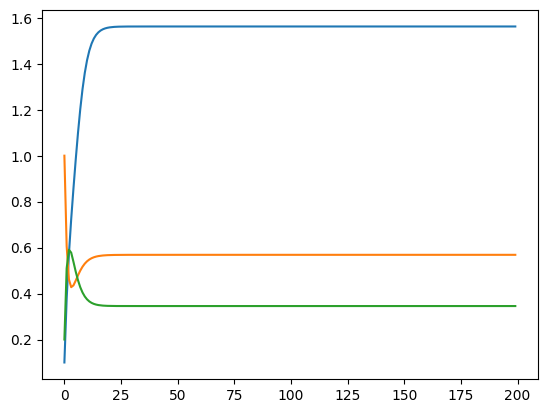

In [594]:
dyn = odeint(system, init, tseries, args=(cg_eco,))
plt.plot(dyn)
dyn[-1,]

1.4608 0.194
1.20319616 0.23365668
1.1018515199999999 0.25338534
1.05781952 0.266987796
1.0414995200000001 0.32057288
0.97186944 0.320987392
0.91217024 0.32958869599999996
0.92713024 0.37301490400000004
0.94091776 0.40555932800000005
0.9280767999999999 0.41002
0.92394752 0.438143968
0.91088704 0.4643839719999999
0.9358432000000001 0.49957048000000004
0.99393152 0.573159272
0.99863296 0.59964632
1.05263872 0.647275824
1.0452128 0.65303722
1.0557632000000001 0.6866860000000001
1.06734848 0.6909112479999999
1.09610112 0.726940744
1.16485824 0.8031891839999998
1.21444288 0.8465894759999999
1.2539955200000001 0.8862068160000001
1.2148953599999999 0.85499352
1.2848486399999999 0.938991296
1.29624384 0.934697736
1.3231699199999998 0.9886365639999999
1.33741504 0.987842168
1.36722624 0.9954263319999999
1.3379027200000002 0.9624100200000001
1.408112 1.022556484
1.5093996800000002 1.100715712
1.54514368 1.14261802
1.51258304 1.126061096
1.4883705600000001 1.068952664
1.5725510400000002 1.1511286

()

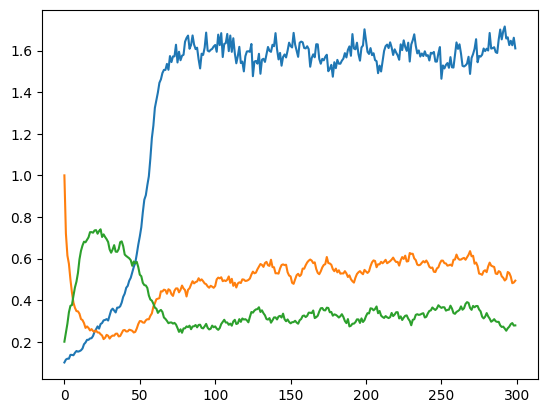

In [595]:
np.random.seed(1)
V = 5000
xx = tau_leap(init * V, sys_birth, sys_death, 300, 0.1, cg_eco, V)
plt.plot(xx['x']/V)
np.shape(xx)

In [596]:
cg_evo =  Config(dict(eta = 1., g = 0.312, mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1, 
                      r = 2.3, d = 1.3, theta = 8., v = 1., h = 1.5, nu_max = 3))

In [597]:
tau(3.6, -0.2, cg_evo)

1.1008013654105298

In [598]:
np.random.seed(1)
V = 5000
dyn_stoc = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 200, dt = 0.1, cg = cg_evo, V = V, 
                                       trait_init = np.array([3.6, -0.2]), sigma_rho = 0.5, sigma_nu = 0.3, 
                                       mutant_rate = 0)

(array([1.46080137]), array([0.194]))
(array([1.2456407]), array([0.23875789]))
(array([1.09813271]), array([0.2303789]))
(array([1.08082508]), array([0.29004611]))
(array([1.07397126]), array([0.32303113]))
(array([1.08905664]), array([0.37550166]))
(array([1.09073016]), array([0.4292427]))
(array([1.04418676]), array([0.4201651]))
(array([1.02718128]), array([0.44503916]))
(array([1.02176685]), array([0.46760896]))
(array([1.0609982]), array([0.52498804]))
(array([1.10734057]), array([0.58758456]))
(array([1.24457512]), array([0.71293952]))
(array([1.25348326]), array([0.74027662]))
(array([1.30917348]), array([0.82784499]))
(array([1.34631012]), array([0.8642362]))
(array([1.36786852]), array([0.88855316]))
(array([1.43412066]), array([0.96890118]))
(array([1.43568547]), array([0.97531682]))
(array([1.5414122]), array([1.07812544]))
(array([1.63587493]), array([1.1821838]))
(array([1.74432739]), array([1.31883106]))
(array([1.80953765]), array([1.37852027]))
(array([1.90633316]), ar

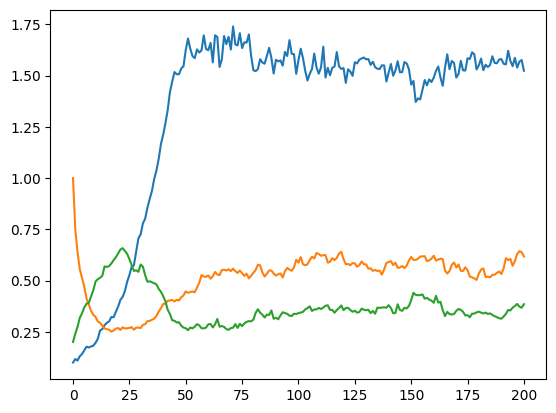

In [599]:
plt.plot(np.array(dyn_stoc["x_F"])/V)
plt.plot(np.array(dyn_stoc["x_A"])/V)
plt.plot(np.array(dyn_stoc["x_H"])/V)

In [586]:
sys_birth(init * V, cg_eco, V)

array([1.4608, 0.272 , 2.53  ])

In [589]:
F_birth_mut(init[0:1] * V, init[1:2] * V, cg_evo, V=V,rho_mut = 3.6,nu_mut = -0.2)

array([1.46080137])

In [590]:
sys_death(init * V, cg_eco, V)

array([0.194 , 2.576 , 0.5972])

In [591]:
F_death_mut(init[0:1] * V, init[1:2] * V, init[2:3] * V, cg_evo, V=V,rho_mut = 3.6,nu_mut = -0.2)

array([0.194])